In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

In [18]:
# Link: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

df = pd.read_csv("../data/sign_mnist.csv")

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [19]:
X = df.drop(columns="label")
y = df["label"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
# Scales the pixel values from the original range of 0 to 255 to a normalized range between 0 and 1.
# Trains faster and improves overall performance.
X_train = X_train.values / 255.0
X_test = X_test.values / 255.0

In [22]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

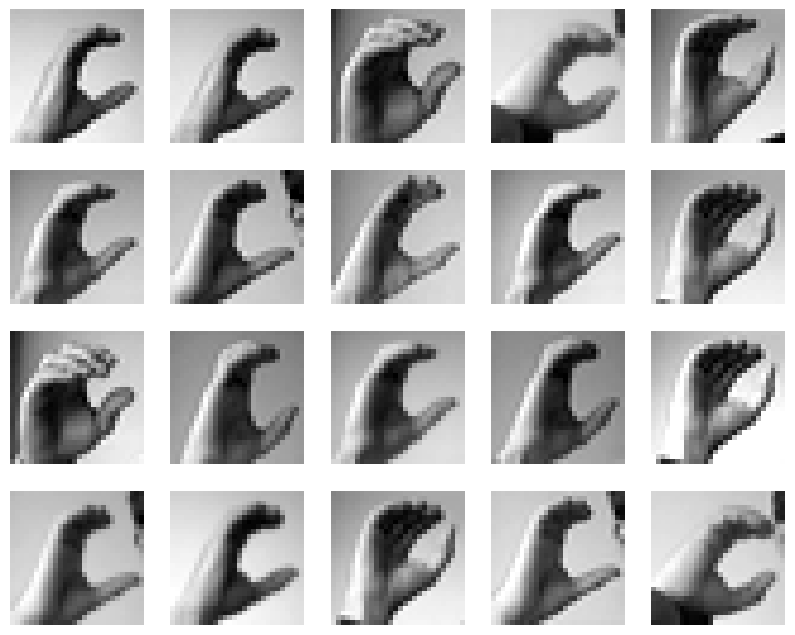

In [23]:
plt.figure(figsize=(10, 8))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[y_train == 2][i], cmap="grey")
    plt.axis("off")

plt.savefig("../images/variations.png", bbox_inches="tight")

In [24]:
X_train[0].shape

(28, 28, 1)

In [25]:
model = Sequential()

model.add(Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2))

model.add(Conv2D(64, 3, activation="relu"))
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 3, activation="relu"))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(25, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(
    patience=3, monitor="val_loss", restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping],
)

Epoch 1/20
812/812 [==============================] - 8s 9ms/step - loss: 1.2921 - acc: 0.5797 - val_loss: 0.3774 - val_acc: 0.8807
Epoch 2/20
812/812 [==============================] - 7s 8ms/step - loss: 0.2416 - acc: 0.9181 - val_loss: 0.0913 - val_acc: 0.9786
Epoch 3/20
812/812 [==============================] - 7s 8ms/step - loss: 0.0665 - acc: 0.9812 - val_loss: 0.0288 - val_acc: 0.9951
Epoch 4/20
812/812 [==============================] - 7s 8ms/step - loss: 0.0396 - acc: 0.9885 - val_loss: 0.0124 - val_acc: 0.9983
Epoch 5/20
812/812 [==============================] - 7s 8ms/step - loss: 0.0333 - acc: 0.9910 - val_loss: 0.0121 - val_acc: 0.9978
Epoch 6/20
812/812 [==============================] - 7s 8ms/step - loss: 0.0024 - acc: 0.9999 - val_loss: 0.0050 - val_acc: 0.9991
Epoch 7/20
812/812 [==============================] - 7s 8ms/step - loss: 0.0283 - acc: 0.9911 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 8/20
812/812 [==============================] - 7s 9ms/step - loss: 6.

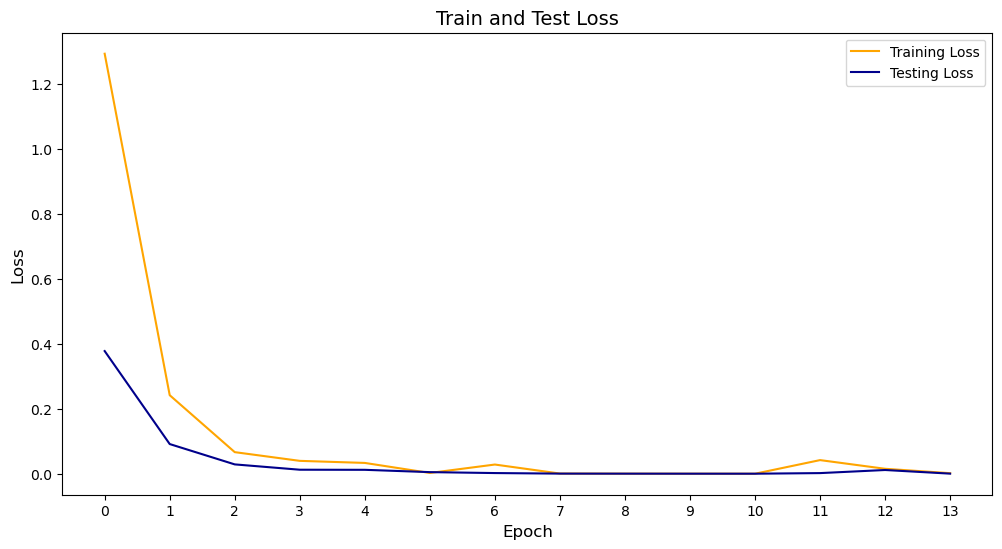

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], c="orange", label="Training Loss")
plt.plot(history.history["val_loss"], c="darkblue", label="Testing Loss")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Loss", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.legend()
plt.savefig("../images/train_test_loss.png", bbox_inches="tight")

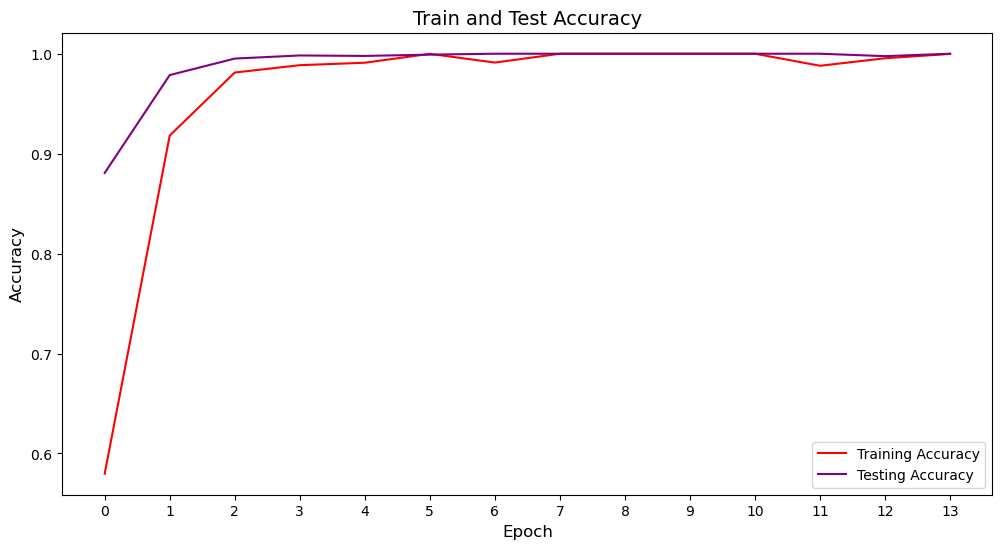

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(history.history["acc"], c="red", label="Training Accuracy")
plt.plot(history.history["val_acc"], c="purple", label="Testing Accuracy")

x_ticks = [i for i in range(0, len(history.history["loss"]), 1)]
plt.xticks(x_ticks, x_ticks)

plt.title("Train and Test Accuracy", size=14)
plt.xlabel("Epoch", size=12)
plt.ylabel("Accuracy", size=12)
plt.legend()
plt.savefig("../images/train_test_acc.png", bbox_inches="tight")

In [28]:
print(
    f"Train: {model.evaluate(X_train, y_train)}\nTest: {model.evaluate(X_test, y_test)}"
)

271/271 [==============================] - 1s 3ms/step - loss: 1.4122e-04 - acc: 1.0000
Train: [6.095537173678167e-05, 1.0]
Test: [0.00014121885760687292, 1.0]


In [29]:
y_pred = np.argmax(model.predict(X_test), axis=1)

271/271 [==============================] - 1s 3ms/step


In [30]:
# Displays images that were predicted incorrectly

wrong_ix = np.where(y_pred != y_test)[0]
for i in wrong_ix[:10]:
    plt.clf()
    plt.axis("off")
    plt.imshow(X_test[i], cmap="plasma")
    plt.show()
    pred = y_pred[i]
    truth = y_test[i]
    print(f"Predicted {pred} - Actual {truth}")

In [31]:
# Save model
model.save("../data/model.h5")